# Attention & трансформеры

In [88]:
import os
import tqdm
from dotenv import load_dotenv
from huggingface_hub import login

In [89]:
load_dotenv()

True

In [90]:
HF_TOKEN = os.getenv("HF_TOKEN")

if not HF_TOKEN:
    raise ValueError("Токен не найден! Проверьте файл .env")

In [91]:
login(token=HF_TOKEN)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [92]:
from huggingface_hub import whoami
user_info = whoami()
print(f"Вы вошли как: {user_info['name']}")

Вы вошли как: viv232


## Задание 1. Подготовка данных и модели

### Выбор датасета

Для дообучения модели на русскоязычном наборе используем датасет Vikhrmodels/GrandMaster-PRO-MAX

In [93]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [8]:
dataset = load_dataset(
    "Vikhrmodels/GrandMaster-PRO-MAX",
    revision="main"
)

In [9]:
print(f"Доступные разделы: {list(dataset.keys())}")
print(f"Пример данных: {dataset['train'][0]}")

Доступные разделы: ['train', 'test']
Пример данных: {'source': 'generated/saiga/tagengo/lmsys_pref', 'conversation': [{'content': 'мне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.', 'role': 'user'}, {'content': 'Расскажу тебе о стратегиях игры в Ним и затрону тему 15 Puzzle.\n\n### Стратегия оптимальной игры в Ним\n\nИгра Ним — это математическая игра, для которой существует чёткая выигрышная стратегия. Основа стратегии лежит в понятии ним-суммы — это побитовое исключающее ИЛИ (XOR) размеров кучек.\n\nОптимальная стратегия заключается в следующем:\n\n1. Вычисли ним-сумму всех кучек.\n2. Если ним-сумма ра

In [10]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [11]:
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("\nПример train записи:")
print(train_dataset[0])

Train samples: 151822
Test samples: 3291

Пример train записи:
{'source': 'generated/saiga/tagengo/lmsys_pref', 'conversation': [{'content': 'мне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.', 'role': 'user'}, {'content': 'Расскажу тебе о стратегиях игры в Ним и затрону тему 15 Puzzle.\n\n### Стратегия оптимальной игры в Ним\n\nИгра Ним — это математическая игра, для которой существует чёткая выигрышная стратегия. Основа стратегии лежит в понятии ним-суммы — это побитовое исключающее ИЛИ (XOR) размеров кучек.\n\nОптимальная стратегия заключается в следующем:\n\n1. Вычисли ним-сумму всех кучек.\n2. Если н

### Предварительная обработка данных

In [94]:
from collections import Counter

In [95]:
lang_pairs = [(ex['prompt_lang'], ex['answer_lang']) for ex in train_dataset]
print("Языковые пары в исходном train:")
print(Counter(lang_pairs).most_common())

Языковые пары в исходном train:
[(('ru', 'ru'), 86295), (('en', 'ru'), 37976), (('en', 'en'), 24150), (('ru', 'en'), 264), (('en', 'zh'), 234), (('zh', 'ru'), 200), (('zh', 'zh'), 171), (('es', 'es'), 165), (('en', 'es'), 123), (('uk', 'ru'), 117), (('it', 'it'), 102), (('pt', 'pt'), 96), (('ja', 'en'), 86), (('ja', 'ru'), 85), (('en', 'de'), 84), (('bg', 'ru'), 72), (('fr', 'fr'), 67), (('de', 'ru'), 64), (('fr', 'ru'), 59), (('en', 'pt'), 59), (('en', 'fr'), 56), (('de', 'en'), 53), (('en', 'it'), 49), (('de', 'de'), 43), (('es', 'en'), 43), (('it', 'en'), 40), (('ru', 'fr'), 39), (('zh', 'en'), 39), (('fr', 'en'), 38), (('es', 'ru'), 36), (('pt', 'en'), 34), (('pt', 'ru'), 30), (('ru', 'bg'), 29), (('it', 'ru'), 27), (('sr', 'ru'), 25), (('mk', 'ru'), 18), (('bn', 'ru'), 18), (('en', 'ja'), 17), (('en', 'tr'), 15), (('ru', 'it'), 14), (('en', 'eo'), 14), (('nl', 'nl'), 13), (('en', 'uk'), 13), (('el', 'ru'), 12), (('cs', 'ru'), 12), (('sv', 'sv'), 12), (('es', 'pt'), 12), (('en', 'b

In [14]:
def filter_russian(example):
    return example['prompt_lang'] == 'ru' and example['answer_lang'] == 'ru'

In [15]:
train_dataset_ru = train_dataset.filter(filter_russian)
test_dataset_ru = test_dataset.filter(filter_russian)

In [16]:
len(train_dataset_ru), len(test_dataset_ru)

(86295, 1886)

In [17]:
if len(train_dataset_ru) > 20000:
    train_dataset_ru_20k = train_dataset_ru.select(range(20000))

In [18]:
train_dataset_ru_20k[0]

{'source': 'generated/saiga/tagengo/lmsys_pref',
 'conversation': [{'content': 'мне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.',
   'role': 'user'},
  {'content': 'Расскажу тебе о стратегиях игры в Ним и затрону тему 15 Puzzle.\n\n### Стратегия оптимальной игры в Ним\n\nИгра Ним — это математическая игра, для которой существует чёткая выигрышная стратегия. Основа стратегии лежит в понятии ним-суммы — это побитовое исключающее ИЛИ (XOR) размеров кучек.\n\nОптимальная стратегия заключается в следующем:\n\n1. Вычисли ним-сумму всех кучек.\n2. Если ним-сумма равна нулю, то ваше положение проигрышное при оп

In [19]:
print(train_dataset_ru_20k[0]['conversation'][1]['content'])

Расскажу тебе о стратегиях игры в Ним и затрону тему 15 Puzzle.

### Стратегия оптимальной игры в Ним

Игра Ним — это математическая игра, для которой существует чёткая выигрышная стратегия. Основа стратегии лежит в понятии ним-суммы — это побитовое исключающее ИЛИ (XOR) размеров кучек.

Оптимальная стратегия заключается в следующем:

1. Вычисли ним-сумму всех кучек.
2. Если ним-сумма равна нулю, то ваше положение проигрышное при оптимальной игре соперника. В этом случае просто делайте ход и старайтесь создать трудности для соперника.
3. Если ним-сумма не равна нулю, вам нужно сделать ход, который уменьшит размер одной из кучек так, чтобы новая ним-сумма всех кучек была равна нулю.
4. После вашего хода соперник окажется в положении с ним-суммой равной нулю, что является проигрышным положением при вашей оптимальной игре.

### Играем в крестики-нолики

Что касается крестиков-ноликов, можно попробовать игру на расширенном поле 5x5 или 10x10, где для победы нужно выстроить ряд из 5 символо

In [20]:
print(train_dataset_ru_20k[1]['conversation'][0]['content'])

слушай, у меня тут возникла задачка по архитектуре компьютера, и я не могу в ней разобраться. мне нужно разработать алгоритм, который оптимизирует доступ к кэш-памяти в многоядерном процессоре для параллельных вычислений. ты не мог бы помочь с этим? вот как я представляю задачу:

1. имеется многоядерный процессор с общим кэшем второго уровня.
2. необходимо минимизировать промахи кэша при параллельном выполнении нескольких интенсивных задач по обработке данных.
3. алгоритм должен распределять данные таким образом, чтобы максимально использовать преимущества локальности данных и минимизировать конфликтные промахи.

может есть идеи, как это можно организовать на уровне алгоритма? буду рад любым предложениям и советам!


In [21]:
lang_pairs_ru = [(ex['prompt_lang'], ex['answer_lang']) for ex in train_dataset_ru_20k]
print("\nЯзыковые пары после фильтрации:")
print(Counter(lang_pairs_ru).most_common())


Языковые пары после фильтрации:
[(('ru', 'ru'), 20000)]


In [22]:
def create_conversation(sample):
  return {
      "messages": [
          {"role": "user", "content": sample['conversation'][0]['content']},
          {"role": "assistant", "content": sample['conversation'][1]['content']}
      ]
  }

In [23]:
create_conversation(train_dataset_ru_20k[1])

{'messages': [{'role': 'user',
   'content': 'слушай, у меня тут возникла задачка по архитектуре компьютера, и я не могу в ней разобраться. мне нужно разработать алгоритм, который оптимизирует доступ к кэш-памяти в многоядерном процессоре для параллельных вычислений. ты не мог бы помочь с этим? вот как я представляю задачу:\n\n1. имеется многоядерный процессор с общим кэшем второго уровня.\n2. необходимо минимизировать промахи кэша при параллельном выполнении нескольких интенсивных задач по обработке данных.\n3. алгоритм должен распределять данные таким образом, чтобы максимально использовать преимущества локальности данных и минимизировать конфликтные промахи.\n\nможет есть идеи, как это можно организовать на уровне алгоритма? буду рад любым предложениям и советам!'},
  {'role': 'assistant',
   'content': 'Ваша задача действительно интересная и актуальная в контексте современных многоядерных процессоров. Для оптимизации доступа к кэш-памяти важно учитывать такие аспекты, как пространс

In [24]:
train_ru_cr = train_dataset_ru_20k.map(create_conversation, remove_columns=train_dataset_ru_20k.features, batched=False)
test_ru_cr = test_dataset_ru.map(create_conversation, remove_columns=test_dataset_ru.features, batched=False)

Map: 100%|██████████| 20000/20000 [00:01<00:00, 14548.86 examples/s]


In [25]:
train_ru_cr[0]

{'messages': [{'content': 'мне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.',
   'role': 'user'},
  {'content': 'Расскажу тебе о стратегиях игры в Ним и затрону тему 15 Puzzle.\n\n### Стратегия оптимальной игры в Ним\n\nИгра Ним — это математическая игра, для которой существует чёткая выигрышная стратегия. Основа стратегии лежит в понятии ним-суммы — это побитовое исключающее ИЛИ (XOR) размеров кучек.\n\nОптимальная стратегия заключается в следующем:\n\n1. Вычисли ним-сумму всех кучек.\n2. Если ним-сумма равна нулю, то ваше положение проигрышное при оптимальной игре соперника. В этом случае просто делайт

In [26]:
len(train_ru_cr)

20000

In [27]:
train_ru_cr.save_to_disk("train_ru_cr_20k")
test_ru_cr.save_to_disk("test_ru_cr_20k")

Saving the dataset (1/1 shards): 100%|██████████| 1886/1886 [00:00<00:00, 271259.08 examples/s]


In [15]:
from datasets import load_from_disk
train_ru_cr = load_from_disk("train_ru_cr_20k")
test_ru_cr = load_from_disk("test_ru_cr_20k")

### Выбор предобученной модели

Для дообучения выбираю модель на 270 миллионов параметров: google/gemma-3-270m-it

In [28]:
base_model = "google/gemma-3-270m-it"
checkpoint_dir = "./checkpoint" #@param {type:"string"}
learning_rate = 5e-5 #@param {type:"number"}

## Задание 2. Дообучение модели

### Предварительная оценка качества

In [96]:
from transformers import pipeline

from random import randint
import re

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [97]:
print(f"Доступные GPU: {torch.cuda.device_count()}")
print(f"Названия GPU: {[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]}")

Доступные GPU: 2
Названия GPU: ['NVIDIA GeForce RTX 3090 Ti', 'NVIDIA GeForce RTX 3090']


In [32]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype="auto",
    device_map="balanced",     # device_map="auto",
    # device_map={"": "cuda:0"},  # Все слои на cuda:0
    attn_implementation="eager"
)

In [33]:
print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

Device: cuda:1
DType: torch.bfloat16


In [34]:
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [35]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:1


In [36]:
train_ru_cr[0]['messages'][0]['content']

'мне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.'

In [37]:
example = train_ru_cr[0]
example

{'messages': [{'content': 'мне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.',
   'role': 'user'},
  {'content': 'Расскажу тебе о стратегиях игры в Ним и затрону тему 15 Puzzle.\n\n### Стратегия оптимальной игры в Ним\n\nИгра Ним — это математическая игра, для которой существует чёткая выигрышная стратегия. Основа стратегии лежит в понятии ним-суммы — это побитовое исключающее ИЛИ (XOR) размеров кучек.\n\nОптимальная стратегия заключается в следующем:\n\n1. Вычисли ним-сумму всех кучек.\n2. Если ним-сумма равна нулю, то ваше положение проигрышное при оптимальной игре соперника. В этом случае просто делайт

In [38]:
prompt = pipe.tokenizer.apply_chat_template(example["messages"][:1], tokenize=False, add_generation_prompt=True)
prompt

'<bos><start_of_turn>user\nмне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.<end_of_turn>\n<start_of_turn>model\n'

In [39]:
outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)
outputs

[{'generated_text': '<bos><start_of_turn>user\nмне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.<end_of_turn>\n<start_of_turn>model\nОтлично, я рад помочь! 15 puzzle - это отличный выбор для стратегических игр. Они предлагают множество возможностей для развития логики, решения задач и создания интересных и запоминающихся комбинаций.\n\nЧтобы предложить тебе наиболее подходящую стратегию, мне нужно немного больше информации о твоих предпочтениях. Что тебе больше нравится в стратегических играх? Какие типы задач тебе интересны? Какие у тебя есть любимые стратегии?\n\nВ любом случае, вот несколько популярных

In [40]:
print(f"Вопрос:\n{example['messages'][0]['content']}\n\n")
print(f"Ответ из датасета:\n{example['messages'][1]['content']}\n\n")
print(f"Сгенерированный ответ:\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Вопрос:
мне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.


Ответ из датасета:
Расскажу тебе о стратегиях игры в Ним и затрону тему 15 Puzzle.

### Стратегия оптимальной игры в Ним

Игра Ним — это математическая игра, для которой существует чёткая выигрышная стратегия. Основа стратегии лежит в понятии ним-суммы — это побитовое исключающее ИЛИ (XOR) размеров кучек.

Оптимальная стратегия заключается в следующем:

1. Вычисли ним-сумму всех кучек.
2. Если ним-сумма равна нулю, то ваше положение проигрышное при оптимальной игре соперника. В этом случае просто делайте ход и старайтесь создать трудности для соп

In [41]:
example_2 = train_ru_cr[3]
example_2

{'messages': [{'content': 'Расскажи преимущества сайта https://www.chesskid.com',
   'role': 'user'},
  {'content': 'Сайт ChessKid.com является образовательной платформой, предназначенной для детей, желающих изучать шахматы. К его преимуществам можно отнести:\n\n### Обучающая Среда:\n\n**1. Дружелюбный интерфейс:**\n   ChessKid разработан с учетом детей, поэтому имеет привлекательный и понятный интерфейс, который делает процесс обучения увлекательным.\n\n**2. Интерактивные уроки:**\n   Платформа предлагает массу уроков, которые обучают детей основам шахмат и продвинутым стратегиям с помощью интерактивных заданий и видео.\n\n### Безопасность:\n\n**3. Безопасное общение:**\n   ChessKid обеспечивает безопасную среду для детей, где они могут общаться и играть без риска столкнуться с неподобающим контентом или общением.\n\n**4. Контроль со стороны родителей и учителей:**\n   Взрослые могут создавать аккаунты и управлять ими, следить за прогрессом детей и контролировать, с кем они взаимодейс

In [42]:
prompt = pipe.tokenizer.apply_chat_template(example_2["messages"][:1], tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)
outputs

[{'generated_text': '<bos><start_of_turn>user\nРасскажи преимущества сайта https://www.chesskid.com<end_of_turn>\n<start_of_turn>model\nThe ChessKid website is a fantastic platform for learning chess and chess-playing. Here are some of its key benefits:\n\n*   **Comprehensive Content:** The website offers a vast library of articles, videos, and tutorials covering various aspects of chess, including strategy, tactics, tactics, and world chess.\n*   **Interactive Gameplay:** ChessKid features a dynamic and engaging interactive experience. Players can play against other players, see their moves, and analyze their strategies.\n*   **Educational Resources:** The website provides a wealth of educational resources, including games, articles, and tips for improving your skills.\n*   **Community:** ChessKid fosters a supportive community where players can share their experiences, ask questions, and learn from each other.\n*   **Different Learning Styles:** The website caters to various learning

In [43]:
print(f"Вопрос:\n{example_2['messages'][0]['content']}\n\n")
print(f"Ответ из датасета:\n{example_2['messages'][1]['content']}\n\n")
print(f"Сгенерированный ответ:\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Вопрос:
Расскажи преимущества сайта https://www.chesskid.com


Ответ из датасета:
Сайт ChessKid.com является образовательной платформой, предназначенной для детей, желающих изучать шахматы. К его преимуществам можно отнести:

### Обучающая Среда:

**1. Дружелюбный интерфейс:**
   ChessKid разработан с учетом детей, поэтому имеет привлекательный и понятный интерфейс, который делает процесс обучения увлекательным.

**2. Интерактивные уроки:**
   Платформа предлагает массу уроков, которые обучают детей основам шахмат и продвинутым стратегиям с помощью интерактивных заданий и видео.

### Безопасность:

**3. Безопасное общение:**
   ChessKid обеспечивает безопасную среду для детей, где они могут общаться и играть без риска столкнуться с неподобающим контентом или общением.

**4. Контроль со стороны родителей и учителей:**
   Взрослые могут создавать аккаунты и управлять ими, следить за прогрессом детей и контролировать, с кем они взаимодействуют.

### Игровой Процесс:

**5. Адаптируемые игр

### Настройка процесса обучения

In [44]:
from trl import SFTConfig
from trl import SFTTrainer

In [45]:
torch_dtype = model.dtype

In [46]:
model.dtype

torch.bfloat16

In [47]:
from transformers import AutoModel

try:
    model = AutoModel.from_pretrained("gpt2", attn_implementation="flash_attention_2")
    print("✅ Flash Attention успешно установлен и работает!")
except Exception as e:
    print(f"❌ Ошибка: {e}")

❌ Ошибка: FlashAttention2 has been toggled on, but it cannot be used due to the following error: the package flash_attn seems to be not installed. Please refer to the documentation of https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2 to install Flash Attention 2.


In [48]:
args = SFTConfig(
    output_dir=checkpoint_dir,              # directory to save and repository id
    max_length=512,                         # max sequence length for model and packing of the dataset
    packing=False,                          # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_checkpointing=False,           # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=1,  # 10                      # log every step
    save_strategy="epoch",                  # save checkpoint every epoch
    eval_strategy="epoch",                  # evaluate checkpoint every epoch
    learning_rate=learning_rate,            # learning rate
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precision
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=False,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    dataloader_num_workers=4,
    dataset_kwargs={
        "add_special_tokens": False, # Template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    }
)

In [49]:
print("Распределение модели по устройствам:")
for name, param in model.named_parameters():
    print(f"{name}: {param.device}")

Распределение модели по устройствам:
model.embed_tokens.weight: cuda:1
model.layers.0.self_attn.q_proj.weight: cuda:1
model.layers.0.self_attn.k_proj.weight: cuda:1
model.layers.0.self_attn.v_proj.weight: cuda:1
model.layers.0.self_attn.o_proj.weight: cuda:1
model.layers.0.self_attn.q_norm.weight: cuda:1
model.layers.0.self_attn.k_norm.weight: cuda:1
model.layers.0.mlp.gate_proj.weight: cuda:1
model.layers.0.mlp.up_proj.weight: cuda:1
model.layers.0.mlp.down_proj.weight: cuda:1
model.layers.0.input_layernorm.weight: cuda:1
model.layers.0.post_attention_layernorm.weight: cuda:1
model.layers.0.pre_feedforward_layernorm.weight: cuda:1
model.layers.0.post_feedforward_layernorm.weight: cuda:1
model.layers.1.self_attn.q_proj.weight: cuda:1
model.layers.1.self_attn.k_proj.weight: cuda:1
model.layers.1.self_attn.v_proj.weight: cuda:1
model.layers.1.self_attn.o_proj.weight: cuda:1
model.layers.1.self_attn.q_norm.weight: cuda:1
model.layers.1.self_attn.k_norm.weight: cuda:1
model.layers.1.mlp.ga

In [50]:
from huggingface_hub import HfApi

api = HfApi(token=HF_TOKEN)
try:
    api.model_info("google/gemma-3-270m-it")
    print("✅ Доступ подтвержден")
except Exception as e:
    print(f"❌ Ошибка доступа: {e}")
    print("Проверьте настройки токена и принятие лицензии")

✅ Доступ подтвержден


In [51]:
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_ru_cr,
    eval_dataset=test_ru_cr,
    processing_class=tokenizer,
)

Truncating train dataset: 100%|██████████| 20000/20000 [00:00<00:00, 224801.04 examples/s]


In [52]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.790600,1.843645
2,1.381900,1.834362
3,1.300800,1.869938


TrainOutput(global_step=15000, training_loss=1.6829673868298531, metrics={'train_runtime': 2812.6724, 'train_samples_per_second': 21.332, 'train_steps_per_second': 5.333, 'total_flos': 1.8457011675669504e+16, 'train_loss': 1.6829673868298531})

In [56]:
trainer.save_model("2025_08_17_model_g3_270m_20k")
tokenizer.save_pretrained("2025_08_17_model_g3_270m_20k")

('2025_08_17_model_g3_270m_20k\\tokenizer_config.json',
 '2025_08_17_model_g3_270m_20k\\special_tokens_map.json',
 '2025_08_17_model_g3_270m_20k\\chat_template.jinja',
 '2025_08_17_model_g3_270m_20k\\tokenizer.model',
 '2025_08_17_model_g3_270m_20k\\added_tokens.json',
 '2025_08_17_model_g3_270m_20k\\tokenizer.json')

In [54]:
import matplotlib.pyplot as plt

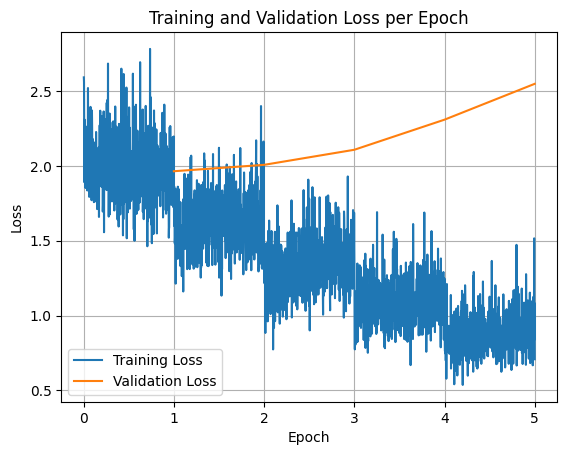

In [31]:
log_history = trainer.state.log_history

train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

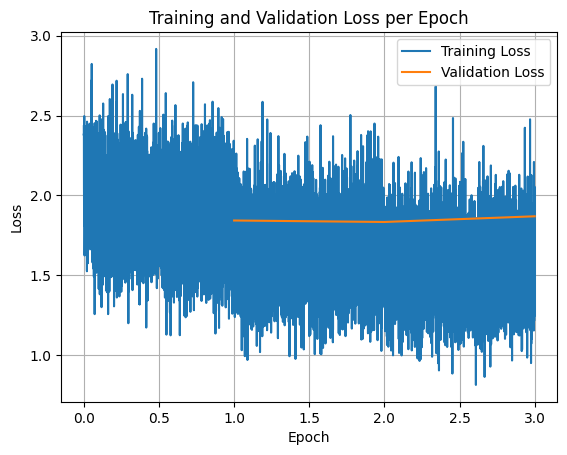

In [55]:
log_history = trainer.state.log_history

train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

### Оценка качества обучения

In [63]:
device = model.device  # Определите текущее устройство модели
print(f"Модель находится на устройстве: {device}")

Модель находится на устройстве: cuda:0


In [140]:
import gc

# Удаляем модель и pipeline
del model
del pipe
del tokenizer

# Очищаем кеш CUDA
torch.cuda.empty_cache()

# Принудительный сбор мусора
gc.collect()

# Проверяем свободную память
print(f"Свободно памяти на CUDA: {torch.cuda.memory_allocated(device)/1e9:.2f}GB / {torch.cuda.get_device_properties(device).total_memory/1e9:.2f}GB")

Свободно памяти на CUDA: 2.19GB / 25.76GB


In [82]:
# model = model.to(main_device)

In [83]:
import tqdm
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import torch

In [84]:
model_path = "2025_08_17_model_g3_270m_20k" # "./checkpoint" 

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map={"": "cuda:0"},  # Явно указываем устройство
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(model_path)

device = 0  # cuda:0

In [77]:
pipe = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer
)

Device set to use cuda:0


In [68]:
example = train_ru_cr[0]
example

{'messages': [{'content': 'мне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.',
   'role': 'user'},
  {'content': 'Расскажу тебе о стратегиях игры в Ним и затрону тему 15 Puzzle.\n\n### Стратегия оптимальной игры в Ним\n\nИгра Ним — это математическая игра, для которой существует чёткая выигрышная стратегия. Основа стратегии лежит в понятии ним-суммы — это побитовое исключающее ИЛИ (XOR) размеров кучек.\n\nОптимальная стратегия заключается в следующем:\n\n1. Вычисли ним-сумму всех кучек.\n2. Если ним-сумма равна нулю, то ваше положение проигрышное при оптимальной игре соперника. В этом случае просто делайт

In [69]:
prompt = pipe.tokenizer.apply_chat_template(example["messages"][:1], tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)
outputs

[{'generated_text': '<bos><start_of_turn>user\nмне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.<end_of_turn>\n<start_of_turn>model\nКонечно, я постараюсь помочь тебе разобраться в стратегии игры в игровую игру "Ним". Эта игра - классический пример игры в "Игры со строительными блоками", и для её решения есть ряд правил, которые могут быть вам полезны.\n\n### Выигрышная стратегия в "Ним"\n\nВыигрышная стратегия игры "Ним" заключается в использовании правил стратегического игры, чтобы максимизировать свои шансы на победу. Вот несколько ключевых правил и подходов, которые помогут тебе в победе:\n\n1. **Испо

In [70]:
print(f"Вопрос:\n{example['messages'][0]['content']}\n\n")
print(f"Ответ из датасета:\n{example['messages'][1]['content']}\n\n")
print(f"Сгенерированный ответ:\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Вопрос:
мне очень интересны стратегические игры, и я недавно узнал про игру ним. не мог бы ты объяснить мне стратегию оптимальной игры в ним? и еще, если есть, поделись интересным вариантом игры в крестики-нолики или другие стратегические головоломки, в которые мы могли бы сыграть вместе. как насчет того, чтобы рассмотреть 15 puzzle? мне бы хотелось узнать, есть ли для неё какая-то выигрышная стратегия или подход, который гарантирует победу.


Ответ из датасета:
Расскажу тебе о стратегиях игры в Ним и затрону тему 15 Puzzle.

### Стратегия оптимальной игры в Ним

Игра Ним — это математическая игра, для которой существует чёткая выигрышная стратегия. Основа стратегии лежит в понятии ним-суммы — это побитовое исключающее ИЛИ (XOR) размеров кучек.

Оптимальная стратегия заключается в следующем:

1. Вычисли ним-сумму всех кучек.
2. Если ним-сумма равна нулю, то ваше положение проигрышное при оптимальной игре соперника. В этом случае просто делайте ход и старайтесь создать трудности для соп

In [71]:
example_2 = train_ru_cr[3]
example_2

{'messages': [{'content': 'Расскажи преимущества сайта https://www.chesskid.com',
   'role': 'user'},
  {'content': 'Сайт ChessKid.com является образовательной платформой, предназначенной для детей, желающих изучать шахматы. К его преимуществам можно отнести:\n\n### Обучающая Среда:\n\n**1. Дружелюбный интерфейс:**\n   ChessKid разработан с учетом детей, поэтому имеет привлекательный и понятный интерфейс, который делает процесс обучения увлекательным.\n\n**2. Интерактивные уроки:**\n   Платформа предлагает массу уроков, которые обучают детей основам шахмат и продвинутым стратегиям с помощью интерактивных заданий и видео.\n\n### Безопасность:\n\n**3. Безопасное общение:**\n   ChessKid обеспечивает безопасную среду для детей, где они могут общаться и играть без риска столкнуться с неподобающим контентом или общением.\n\n**4. Контроль со стороны родителей и учителей:**\n   Взрослые могут создавать аккаунты и управлять ими, следить за прогрессом детей и контролировать, с кем они взаимодейс

In [72]:
prompt = pipe.tokenizer.apply_chat_template(example_2["messages"][:1], tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)
outputs

[{'generated_text': '<bos><start_of_turn>user\nРасскажи преимущества сайта https://www.chesskid.com<end_of_turn>\n<start_of_turn>model\nК сожалению, я не могу предоставить информацию о сайтах, которые вы упомянули, так как я являюсь текстовым инструментом, и у меня нет доступа к внешним сайтам или веб-страницам. Однако я могу рассказать вам об основных преимуществах сайта ChessKid для игроков, интересующихся шахматной схваткой:\n\n1. **Популярность**: ChessKid пользуется большим спросом среди игроков, особенно в странах, где шахматы популярны.\n2. **Брендинг и брендинг**: Сайт предоставляет удобный и узнаваемый бренд, который привлекает игроков.\n3. **Голосовая система**: Сохранение голосовой системы, которая позволяет играть с разными партнёрами.\n4. **Интерактивные элементы**: Включает в себя элементы геймификации, такие как персональные карты и уровни, которые делают игру интересной.\n5. **Мобильное приложение**: Поддержка мобильных устройств, что обеспечивает доступ к игре на любом

In [73]:
print(f"Вопрос:\n{example_2['messages'][0]['content']}\n\n")
print(f"Ответ из датасета:\n{example_2['messages'][1]['content']}\n\n")
print(f"Сгенерированный ответ:\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Вопрос:
Расскажи преимущества сайта https://www.chesskid.com


Ответ из датасета:
Сайт ChessKid.com является образовательной платформой, предназначенной для детей, желающих изучать шахматы. К его преимуществам можно отнести:

### Обучающая Среда:

**1. Дружелюбный интерфейс:**
   ChessKid разработан с учетом детей, поэтому имеет привлекательный и понятный интерфейс, который делает процесс обучения увлекательным.

**2. Интерактивные уроки:**
   Платформа предлагает массу уроков, которые обучают детей основам шахмат и продвинутым стратегиям с помощью интерактивных заданий и видео.

### Безопасность:

**3. Безопасное общение:**
   ChessKid обеспечивает безопасную среду для детей, где они могут общаться и играть без риска столкнуться с неподобающим контентом или общением.

**4. Контроль со стороны родителей и учителей:**
   Взрослые могут создавать аккаунты и управлять ими, следить за прогрессом детей и контролировать, с кем они взаимодействуют.

### Игровой Процесс:

**5. Адаптируемые игр

## Задание 3. Сэмплирование

### 3.1 Эксперименты с сэмплированием

### 3.1.1 Оригинальная Gemma3 270m

In [102]:
torch._dynamo.reset()
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')

In [121]:
model_path = "google/gemma-3-270m-it"

model_o = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map={"": "cuda:0"},  # Явно указываем устройство
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(model_path)

device = 0  # cuda:0

In [122]:
pipe_o = pipeline(
    "text-generation", 
    model=model_o, 
    tokenizer=tokenizer
)

Device set to use cuda:0


In [123]:
example = {
    "messages": [
        {"role": "user", "content": "Опиши достопримечательности Москвы"},
        {"role": "assistant", "content": ""}
    ]
}

In [124]:
prompt = pipe_o.tokenizer.apply_chat_template(
    example["messages"][:1],  # Берем только первый промпт пользователя
    tokenize=False,
    add_generation_prompt=True
)

In [126]:
try:
    outputs = pipe_o(
        prompt,
        max_new_tokens=512,
        do_sample=True,
        temperature=1,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        disable_compile=True  # Отключаем компиляцию
    )
    
    # Выводим результат
    print("\n" + "="*50)
    print("Сгенерированный текст:")
    print("="*50)
    print(outputs[0]['generated_text'])
    print("="*50)
    
except Exception as e:
    print(f"Ошибка при генерации: {e}")
    # Дополнительная диагностика
    print(f"Длина промпта: {len(prompt)} символов")
    print(f"Устройство модели: {model.device}")
    print(f"Устройство токенизатора: {tokenizer.device}")


Сгенерированный текст:
<bos><start_of_turn>user
Опиши достопримечательности Москвы<end_of_turn>
<start_of_turn>model
Москва - это город с богатой историей, культурой, архитектурой и жизнью. Здесь можно увидеть множество достопримечательностей, от исторических памятников до современных впечатлений. Вот краткий обзор основных достопримечательностей Москвы:

**Исторический центр:**

*   **Собор Василия Блаженного Знамя (Собор Святого Михаила):** Один из самых известных и узнаваемых исторических памятников Москвы.  Он является символом города и является центром русской православной церкви.
*   **Дворцовая площадь:**  Самое площадь Москвы, с великолепными зданиями, историческими зданиями, парками и кафе. Здесь можно увидеть знаменитую Василию Блаженного Знамя.
*   **Соборная площадь:**  Огромное сооружение, включающее  огромную площадь,  пасторы,  заповедник,  горостки,  парки и дворцы.  Используется для проведения фестивалей, мероприятий и проведения исторических реконструкций.
*   **Музе

### 3.1.2 Дообученная модель с параметрами оригинальной

In [151]:
try:
    outputs = pipe(
        prompt,
        max_new_tokens=512,
        do_sample=True,
        temperature=1,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        disable_compile=True  # Отключаем компиляцию
    )
    
    # Выводим результат
    print("\n" + "="*50)
    print("Сгенерированный текст:")
    print("="*50)
    print(outputs[0]['generated_text'])
    print("="*50)
    
except Exception as e:
    print(f"Ошибка при генерации: {e}")
    # Дополнительная диагностика
    print(f"Длина промпта: {len(prompt)} символов")
    print(f"Устройство модели: {model.device}")
    print(f"Устройство токенизатора: {tokenizer.device}")


Сгенерированный текст:
<bos><start_of_turn>user
Опиши достопримечательности Москвы<end_of_turn>
<start_of_turn>model
Москва — это город, который заслуживает приобщения как жителей, туристов, а также посетителей со всего мира. От величественных Кремля до исторических зданий и памятников, история и культура полны интересных моментов. Вот некоторые из наиболее значимых достопримечательностей Москвы:

### Кремль

- **Выставочный зал и Кремльский дворец:** Один из крупнейших и значимых памятников архитектуры России, знаменит своими башнями, дворцами и скульптурами.
- **Ново-Енисейский ущелье:** Остров на берегу реки Ногин, основанный Петром I в 1772 году.

### Крем домой

- **Собор Василия Блаженного:** Один из символов Москвы, исторический памятник, также известен своей архитектурой, вписывающимися в городскую среду.

### Крем-Покровь

- **Крем-Покровь:** Один из самых известных исторических памятников в России, с уникальной архитектурой и историей.

### Зимний дворец

- **Зимний дворец №

### 3.1.3 Greedy Decoding (do_sample=False)

In [141]:
model_path = "2025_08_17_model_g3_270m_20k" # "./checkpoint" 

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map={"": "cuda:0"},  # Явно указываем устройство
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(model_path)

device = 0  # cuda:0

In [142]:
pipe = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer
)

Device set to use cuda:0


In [143]:
example = {
    "messages": [
        {"role": "user", "content": "Опиши достопримечательности Москвы"},
        {"role": "assistant", "content": ""}
    ]
}

In [144]:
prompt = pipe.tokenizer.apply_chat_template(
    example["messages"][:1],  # Берем только первый промпт пользователя
    tokenize=False,
    add_generation_prompt=True
)

In [145]:
outputs = pipe(
    prompt,
    max_new_tokens=512,
    do_sample=False,  # Жадное декодирование
    pad_token_id=tokenizer.eos_token_id,
    disable_compile=True
)
print(outputs[0]['generated_text'])
print("\n" + "-"*80 + "\n")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


<bos><start_of_turn>user
Опиши достопримечательности Москвы<end_of_turn>
<start_of_turn>model
Москва - столица России, город, который славится своими историческими памятниками, архитектурой и культурой. Вот некоторые из самых известных достопримечательностей Москвы:

### Кремль
- **Исторический Кремль** - один из самых больших и величественных исторических памятников в мире. Он построен в период правления династии Романовых и был одним из ключевых элементов архитектуры Москвы.
- **Московский Кремль** - один из самых больших и величественных зданий Москвы.

### Покровы и памятники
- **Покровы** - один из самых больших и величественных памятников Москвы. Покровы проходили в Кремле в период правления царя Александра II.

### Собор Василия Блаженного
- **Собор Василия Блаженного** - один из самых красивых и величественных памятников Москвы. Построен в 1783 году и является одним из символов Москвы.

### Покровы и памятники
- **Покровы** - памятник Василия Блаженного, построенный в 1783 году

### 3.1.4 Temperature

In [154]:
for temperature in [0.3, 0.7, 1.2]:
    print(f"temperature: {temperature}")
    print("="*80)
    outputs = pipe(
        prompt,
        max_new_tokens=512,
        do_sample=True,
        temperature=temperature,
        pad_token_id=tokenizer.eos_token_id,
        disable_compile=True
    )
    print(outputs[0]['generated_text'])
    print("\n" + "-"*80 + "\n")

temperature: 0.3
<bos><start_of_turn>user
Опиши достопримечательности Москвы<end_of_turn>
<start_of_turn>model
Москва - столица России, город, который славится своими историческими памятниками, архитектурой и культурой. Вот некоторые из наиболее известных достопримечательностей Москвы:

### Кремль
- **Старый русский Кремль** - один из самых больших и узнаваемых исторических памятников в мире, построенный в эпоху Ним.
- **Монуление царя-престола** - один из самых узнаваемых символов Москвы, построенный в 1905 году.
- **Собор Василия Блаженного** - один из самых красивых и величественных памятников на Кремле.
- **Собор Невский Грозный** - один из самых известных православных соборов, построенный в 1883 году.

### Покровь-патриотический собор
- **Покровь-патриотический собор** - один из самых известных соборов в Москве, построенный в 1883 году.

### Соборы и церкви
- **Собор Спас-дему** - один из самых известных православных соборов, построенный в 1883 году.
- **Собор Василия Блаженного**

### 3.1.5 Top-k (k=30) + Top-p (p=0.95)

In [148]:
print("="*80)
outputs = pipe(
    prompt,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.7,
    top_k=30,        # Ограничение словарного запаса
    top_p=0.95,      # Выбор из ядра распределения
    pad_token_id=tokenizer.eos_token_id,
    disable_compile=True
)
print(outputs[0]['generated_text'])
print("\n" + "-"*80 + "\n")

<bos><start_of_turn>user
Опиши достопримечательности Москвы<end_of_turn>
<start_of_turn>model
Москва – столица Российской Федерации, город, который занимает особое место в истории и культуре России. Вот некоторые из самых известных достопримечательностей Москвы:

### 1. Кремль
Этот величественный величественный величественный замок был основан в 1555 году и считается одним из самых значительных исторических памятников России. Кремль – это здание государственной, построенный на месте осажденных крепостных во времена династии царизма, включая Петрова и Шуковских.

### 2. Собор Василия Блаженного
Одна из самых знаменитых картин в мире, построенная в стиле русского барочного искусства. Главная часть собора расположена в центре города, а в центре – на вершине курьера, откуда открывается великолепный вид на город.

### 3. Старомелловок
Нашествие старого города на Красной площади, где был построен Старомелловок, является одним из самых впечатляющих символов Москвы. Город был возведен в 1883 г

### 3.1.6 Beam Search (beams=3)

In [150]:
print("="*80)
outputs = pipe(
    prompt,
    max_new_tokens=512,
    num_beams=3,          # 3 луча для поиска
    early_stopping=True,   # Остановка при отсутствии улучшений
    pad_token_id=tokenizer.eos_token_id,
    disable_compile=True
)
print(outputs[0]['generated_text'])
print("\n" + "-"*80 + "\n")

<bos><start_of_turn>user
Опиши достопримечательности Москвы<end_of_turn>
<start_of_turn>model
Москва - столица России, город с богатой историей, культурой и архитектурой. Вот некоторые из самых известных достопримечательностей Москвы:

1. **Собор Василия Блаженного** - один из крупнейших православных соборов в мире.
2. **Собор Невский Грозный** - один из крупнейших православных соборов в мире.
3. **Собор Василия Блаженного** - один из крупнейших православных соборов в мире.
4. **Собор Василия Блаженного** - один из крупнейших православных соборов в мире.
5. **Собор Василия Блаженного** - один из крупнейших православных соборов в мире.
6. **Собор Василия Блаженного** - один из крупнейших православных соборов в мире.
7. **Собор Василия Блаженного** - один из крупнейших православных соборов в мире.
8. **Собор Василия Блаженного** - один из крупнейших православных соборов в мире.
9. **Собор Василия Блаженного** - один из крупнейших православных соборов в мире.
10. **Собор Василия Блаженног

### 3.1.7 Min-p (min_p=0.05)

In [152]:
print("="*80)
outputs = pipe(
    prompt,
    max_new_tokens=512,
    do_sample=True,
    min_p=0.05,  # Динамический выбор
    pad_token_id=tokenizer.eos_token_id,
    disable_compile=True
)
print(outputs[0]['generated_text'])

<bos><start_of_turn>user
Опиши достопримечательности Москвы<end_of_turn>
<start_of_turn>model
Москва известна своими историческими и культурными достопримечательностями, которые могут вас удивить. Вот несколько из них:

### Московский Кремль
- **Московский Кремль** - один из крупнейших и самых величественных исторических памятников в мире. Кремль является местом проведения многих исторических и культурных событий.
- **Музей Московского Кремля** - один из крупнейших музеев в мире, где представлены произведения русской и мировой культуры.

### Старый город на Цветном бульваре
- **Старый город на Цветном бульваре** - одно из самых известных исторических зданий Москвы. Озеленение этого величественного здания на Цветном бульваре известное своими садами.

### Собор Василия Блаженного
- **Собор Василия Блаженного** - один из самых известных православных соборов Москвы. Проект собора был возведен в 1773 году и является символом Москвы.

### Московский государственный дух
- **Московский государ

### 3.2 Анализ результатов

Задача генерации текста на русском языке для модели минимального размера в российском культурном контексте выходит за пределы возможностей формирования корректных и достоверных ответов. Однако именно в таких задачах на границе возможностей модели заметнее влияние вносимых изменений.(Да и ответы порой фееричные).

### Оригинальная модель Gemma3 270m

Использование промпта: "Опиши досопримечательности Москвы" с оригинальной моделью выявило ограниченные возможности экстремально малой модели. Однако модель размером 270m отвечает на языке промпта, генерирует связный текст с применением разметки Markdown и иcполняет команду в условиях плохо сформированного контекста для данного домена. Присутствуют нехарактерные языковые конструкции, бОльшая доля фактов является произвольной компоновкой стилизованных под домен сущностей.

### Дообученная модель

Дообученная модель с теми же параметрами также демонстрирует стилистические и семантические проблемы. Однако, обращает на себя внимание, большее количество сущностей имеющих отношение к домену. Их применение часто некорректно, но это реальные объекты и личности.

### Жадное декодирование по максимальной вероятности

Применение Greedy decoding в условиях плохо сформированного распределения приводит к зацикливанию

### Варьирование температуры (0,3 0,7 1,2)

- При значении параметра 0,3 ответ вышел за границу ограничения длины 512 токенов. В ряде случаев возникало зацикливание. При этом значении параметра модели сложнее корректно выполнить требования промпта. Нет описательного текста - перечисление сгалюцинированных сущностей
- При значении параметра 0,7 получен наиболее креативный ответ. В одной из генераций: **Спас на Крови** — место, где произошла битва на Луне между СССР и США.) Больше описательного текста
- При значении параметра 1,2 больше всего "человеческого" текста с описанием. Однако, имеено в таком тексте становятся заметны языковые ошибки в дополнение к семантическим

### Top-k (k=30) + Top-p (p=0.95)

Ответ развёрнутый, отформатированный. Текст более связный. Один из самых удачных вариантов

### Beam Search (beams=3)

Ответ аналогичный жадному декодированию. Короткое качественное начало, дальше галюцинации и зацикливание

### Min-p (min_p=0.05)

Относительно качественный ответ: форматирование, перечисление с описаниями. Онако, полный набор стилистических, семантических и языковых ошибок.

## Выводы

Переобучение малой модели в инзначально периферийном домене (не основной язык, незнакомая семантика) не позволяет достичь качественного результата. Чем меньше модель тем ограниченнее возможности корректно отклонить наиболее выраженное распределение. Нужны изначально русскоязычные отечественные БЯМ среднего и малого размера для получения качественных моделей предельно малого размера.